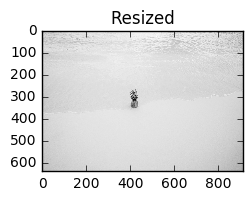

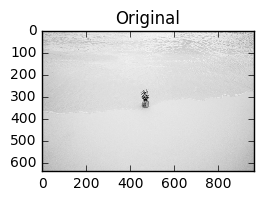

In [12]:
from task_1 import resize_util
import matplotlib.pyplot as plt
import os
import time


start_time = time.time()
path = os.path.join(os.getcwd(), 'task_1', 'sample', 'pineapple.jpg')
orig, res_img = resize_util.load_and_process(path, 50)

plt.figure(1)
plt.subplot(211)
plt.title("Resized")
plt.imshow(res_img, cmap='gray')

plt.figure(2)
plt.subplot(212)
plt.title("Original")
plt.imshow(orig, cmap='gray')
plt.show()

ex_time = time.time() - start_time
# print('Time: ' + '{:f}'.format(ex_time))